In [66]:
# Req Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_ind, chi2_contingency, pearsonr, spearmanr
import xgboost as xgb 

## Manipulate Data

# Read csv into data frame
df = pd.read_csv('nyc_housing_base.csv')


In [67]:
## Clean Data

# Remove dups first (best practice)
df = df.drop_duplicates()

# Drop rows where crucial info is missing and where filling with zero would be detrimental
# Most importantly, remove 6 bad lat rows instead of having them in the ocean
df = df.dropna(subset=["latitude", "sale_price", "bldgarea"])

# Fill missing values with 0; really not good for lat so replaced
# df = df.fillna(0)


In [74]:
##  Numerical Computing

# Convert data frame to numpy array
np_array = df.to_numpy()

# Convert headers to python list
headers_list = df.columns.tolist()

# Define num of cols in csv file
num_cols = 19

# Dict that maps header name to numbered column
header_to_num = {header: number for header, number in zip(headers_list, range(num_cols))}

# Col data for building area, sales price, year built, borough x

# Independent var(s)
building_area_data = np_array[:, header_to_num["bldgarea"]]
yr_built_data = np_array[:, header_to_num["yearbuilt"]]
borough_x_data = np_array[:, header_to_num["borough_x"]]
latitude_data = np_array[:, header_to_num["latitude"]]
longitude_data = np_array[:, header_to_num["longitude"]]
# num_floors_data = np_array[:, header_to_num["numfloors"]

# Dependent var
sales_price_data = np_array[:, header_to_num["sale_price"]]

# Stats computations for building area (sq ft) (X)
mean_sales_price = np.mean(building_area_data)
med_sales_price = np.median(building_area_data)
std_sales_price = np.std(building_area_data)

# Stats computations for sales price (USD) (Y)
mean_sales_price = np.mean(sales_price_data)
med_sales_price = np.median(sales_price_data)
std_sales_price = np.std(sales_price_data)


In [88]:

# ML (sckit-learn)
# Feature(s)

# If using one feature, need to reshape array into single column 2D array
# X = building_area_data.reshape(-1, 1)
# X = burrow_x_data.reshape(-1, 1)

# IF using Z # of features, stack arrays as columns to form single, 2D array with Z columns
# 5 features used here, so stack arrays as cols to form single, 2D array with 5 cols
X = np.column_stack((building_area_data, yr_built_data, borough_x_data, latitude_data, longitude_data))

# Target
y = sales_price_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 10)

## Fit and predict with linear regression model
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()

## Use XBoost regressor for higher accuracy
# Added squared error objective to make model try harder to avoid big outliers bc of big penalities
model = xgb.XGBRegressor(
    objective="reg:squarederror"
    ### Can use these manually entered best-tuned hyperparams (found from GridSearch) instead of running GridSearch
    # n_estimators=500,
    # max_depth=7,
    # learning_rate=0.1,
    # min_child_weight=5,
    # n_jobs=1   
    )

##### Grid Search Block Start

# Fine tune hyperparameters automatically using GridSearch to determine best combination
param_grid = {
    "n_estimators": [100, 500, 1000], # Num trees; 100 to 1000
    "max_depth": [3, 5, 7], # Max depth of tree; 3 to 10
    "learning_rate": [0.01, 0.1, 0.2], # How much to trust each tree built; .01 to .3
    "min_child_weight": [1, 5, 10] # Min size of nodes in tree before prediction; 1 to 10
}   

# Set up Grid Search
grid_search = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    cv = 3, # How many times to test each combination; 3 to be sure
    scoring = "r2", # Trying to maximize R squared (accuracy)
    n_jobs = 1 # Use 1 core to prevent crashes
)

# Run grid search on training data; takes a while depending on hardware (run on Colab for better performance)
print("Starting grid search!")
# Can comment out and use hyperparameter values written below each print statement for best model performance
grid_search.fit(X_train, y_train)

##### Grid Search Block End

## Best Results

print("Best Parameter(s):", grid_search.best_params_)
# Best Parameter(s): {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500}

print("Best Accuracy (R2):", grid_search.best_score_)
# Best Accuracy (R2): 0.32683414220809937

# Update main model with fine tuned hyperparams
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Cross validation (5-fold)
# Returns numpy array of floating point scores
# Each element of returned array is perf metric of model for one specific test fold
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5)

# Print individual scores for each score
print(f"Cross-validation scores: {cv_scores}")
# Cross-validation scores: [0.34770894 0.32589084 0.3692227 0.35472196 0.33221722]

# Print mean score and std across all folds
print(f"Mean CV Score: {np.mean(cv_scores):.2f}")
# Mean CV Score: 0.35

print(f"Standard Deviation of CV Scores: {np.std(cv_scores):.2f}")
# Standard Deviation of CV Scores: 0.02


Starting grid search!
Best Parameter(s): {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 500}
Best Accuracy (R2): 0.32683414220809937
Cross-validation scores: [0.34770894 0.32589084 0.3692227  0.35472196 0.33221722]
Mean CV Score: 0.35
Standard Deviation of CV Scores: 0.02


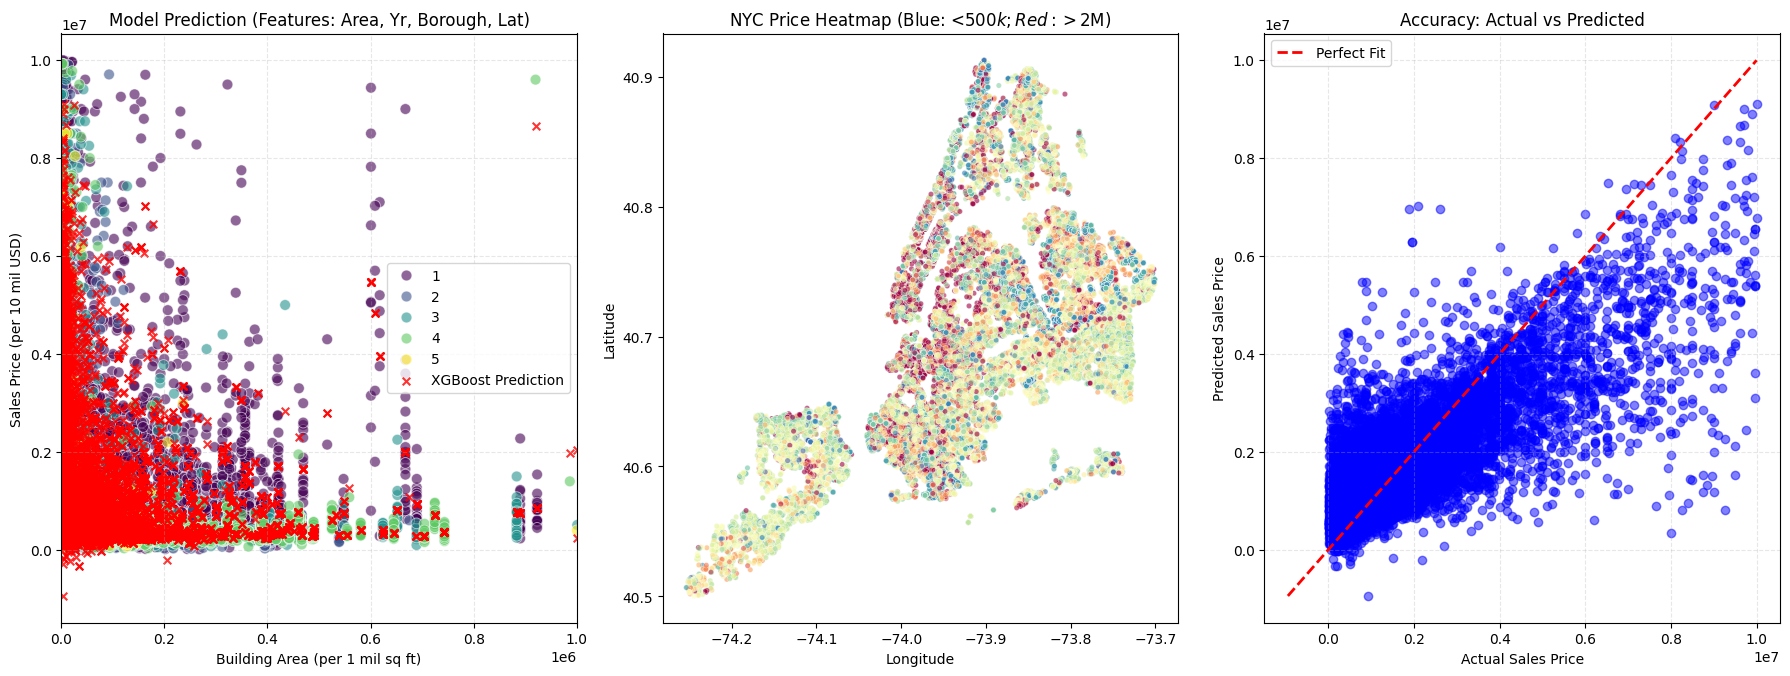

In [89]:
## Data Visualization (Matplotlib)

# Three subplots right next to each other
# Where first is feature slice, second is longitude vs latitude, and third is accuracy check (actual vs predicted)
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

## 1st plot: feature slice (area vs price)

sns.scatterplot( 
    x = building_area_data,
    y = sales_price_data,
    hue = borough_x_data, # Coloring by borough is most intuitive
    palette = "viridis", # Color scheme for categories, Seaborn specific
    s = 60,
    alpha = 0.6, # For transparency
    ax = axes[0] # Set as first (left) subplot
)

# Generate predictions for full list; override previous y_pred for graphing purposes
y_pred = best_model.predict(X)

# Overlay new predictions (red Xs)
axes[0].scatter(
    building_area_data,
    y_pred,
    color = "red",
    marker = "x",
    s = 30,
    label = "XGBoost Prediction",
    alpha = 0.8,
)

# Title
axes[0].set_title(f"Model Prediction (Features: Area, Yr, Borough, Lat)")

# X axis
axes[0].set_xlabel("Building Area (per 1 mil sq ft)")
axes[0].set_xlim(0, 1000000)
# Y axis
axes[0].set_ylabel("Sales Price (per 10 mil USD)")

# Add legend and gridlines for visualization
axes[0].legend()
axes[0].grid(True, linestyle = "--", alpha = .3)

## 2nd plot: longitude versus latitude  

sns.scatterplot(
    x = longitude_data,
    y = latitude_data,
    hue = sales_price_data,
    palette = "Spectral_r", # Palette to show expensive houses blue and cheap houses red
    hue_norm = (0, 2000000), # Cap color scale at 2 mil
    s = 15, 
    alpha = .6, 
    legend = False,
    ax = axes[1]
)
axes[1].set_title("NYC Price Heatmap (Blue: <$500k; Red: >$2M)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")

## 3rd plot: Accuracy check (actual vs predicted)

axes[2].scatter(sales_price_data, y_pred, color="blue", alpha=0.5)

# Calculate max and min vals (start and stop for predicted line) between actual and predicted
min_val = min(min(sales_price_data), min(y_pred))
max_val = max(max(sales_price_data), max(y_pred))

# Plot red dashed line from bottom left to top right
axes[2].plot([min_val, max_val], [min_val, max_val], "r--", linewidth = 2, label = "Perfect Fit")

axes[2].set_title(f"Accuracy: Actual vs Predicted")
axes[2].set_xlabel(f"Actual Sales Price")
axes[2].set_ylabel(f"Predicted Sales Price")

# Legend and gridlines for visualization; dashed line
axes[2].legend()
axes[2].grid(True, linestyle = "--", alpha = .3)

# Calculates padding, resizes, and aligns
plt.tight_layout()

# Show graph
plt.show()